Import prices

In [1]:
import yfinance as yf

msft = yf.Ticker("MSFT")

hist = msft.history(period="1y")

hist = hist.reset_index() 

print(hist)

          Date        Open        High         Low       Close    Volume  \
0   2020-05-29  180.977673  182.502914  178.679929  181.492691  42130400   
1   2020-06-01  180.789494  181.245089  179.719864  181.076721  22622400   
2   2020-06-02  182.483090  183.225898  179.610906  183.136765  30794600   
3   2020-06-03  183.047644  184.156898  181.819529  183.582458  27311000   
4   2020-06-04  182.532634  184.057860  180.551813  181.165863  28761800   
..         ...         ...         ...         ...         ...       ...   
248 2021-05-24  247.789993  251.160004  247.509995  250.779999  21411500   
249 2021-05-25  251.770004  252.750000  250.820007  251.720001  17704300   
250 2021-05-26  251.429993  252.940002  250.750000  251.490005  17771600   
251 2021-05-27  251.169998  251.479996  249.250000  249.309998  24426200   
252 2021-05-28  251.000000  252.080002  249.559998  249.679993  18270200   

     Dividends  Stock Splits  
0          0.0             0  
1          0.0           

Window prices into 30 day windows

In [2]:
import numpy as np

def rolling_window(a, window):
    
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window = 38

window_price_data = rolling_window(hist['Close'].values, window)
window_date_data = rolling_window(hist['Date'].values, window)

print(window_price_data)
print(window_date_data)

[[181.49269104 181.07672119 183.13676453 ... 209.5708313  206.74815369
  209.71936035]
 [181.07672119 183.13676453 183.5824585  ... 206.74815369 209.71936035
  200.59768677]
 [183.13676453 183.5824585  181.16586304 ... 209.71936035 200.59768677
  199.36959839]
 ...
 [248.49620056 247.28898621 249.32427979 ... 250.77999878 251.72000122
  251.49000549]
 [247.28898621 249.32427979 252.66656494 ... 251.72000122 251.49000549
  249.30999756]
 [249.32427979 252.66656494 255.2605896  ... 251.49000549 249.30999756
  249.67999268]]
[['2020-05-29T00:00:00.000000000' '2020-06-01T00:00:00.000000000'
  '2020-06-02T00:00:00.000000000' ... '2020-07-20T00:00:00.000000000'
  '2020-07-21T00:00:00.000000000' '2020-07-22T00:00:00.000000000']
 ['2020-06-01T00:00:00.000000000' '2020-06-02T00:00:00.000000000'
  '2020-06-03T00:00:00.000000000' ... '2020-07-21T00:00:00.000000000'
  '2020-07-22T00:00:00.000000000' '2020-07-23T00:00:00.000000000']
 ['2020-06-02T00:00:00.000000000' '2020-06-03T00:00:00.000000000'


In [3]:
from statsmodels.nonparametric.kernel_regression import KernelReg as kr 

def run_kernel_regressions(window_data: np.array, date_data: np.array, ) -> list: 
    result_list = []
    for i in range(0, len(window_data)):
        
        temp_window_data = {}
        temp_window_data['closing_prices'] = window_data[i]
        temp_window_data['dates'] = date_data[i]
        
        exog = [i for i in range(0, len(temp_window_data['closing_prices']))]
        
        regression_result = kr(endog=temp_window_data['closing_prices'], exog=exog, var_type='c', )
        regression_result = regression_result.fit()[0]
        
        temp_window_data['kernel_regression_line'] = regression_result
        
        result_list = result_list + [temp_window_data, ]

    return result_list

result_list = run_kernel_regressions(
    window_data=window_price_data, date_data=window_date_data, )

print(result_list)

[{'closing_prices': array([181.49269104, 181.07672119, 183.13676453, 183.5824585 ,
       181.16586304, 185.40480042, 186.55368042, 187.97988892,
       194.95236206, 184.48373413, 185.93962097, 187.12811279,
       191.71374512, 192.37728882, 194.43736267, 193.27856445,
       198.64660645, 199.97373962, 195.94277954, 198.41879272,
       194.44723511, 196.53701782, 201.55839539, 202.73698425,
       204.28201294, 208.67944336, 206.25292969, 210.78903198,
       212.26473999, 211.62097168, 205.08425903, 206.35197449,
       206.04493713, 201.96446228, 200.93444824, 209.5708313 ,
       206.74815369, 209.71936035]), 'dates': array(['2020-05-29T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-06-02T00:00:00.000000000', '2020-06-03T00:00:00.000000000',
       '2020-06-04T00:00:00.000000000', '2020-06-05T00:00:00.000000000',
       '2020-06-08T00:00:00.000000000', '2020-06-09T00:00:00.000000000',
       '2020-06-10T00:00:00.000000000', '2020-06-11T00:00:00.000000000',
  

Find local maxima and minima

In [4]:


from scipy.signal import argrelextrema


def find_extrema_from_list_of_series(window_data: dict, ) -> list:
    
    result_list = []
    for i in range(0, len(window_data)):
        
        temp_window_data = window_data[i]
        
        temp_window_data['extrema_x_vals'] = find_extrema(
            regression_line=temp_window_data['kernel_regression_line'], )
        
        temp_window_data['extrema_y_vals'] = [
            temp_window_data['kernel_regression_line'][i] 
            for i in temp_window_data['extrema_x_vals']]
        
        temp_window_data['extrema_dates'] = [
            temp_window_data['dates'][i] 
            for i in temp_window_data['extrema_x_vals']]
        
        result_list = result_list + [temp_window_data, ]
        
    return result_list


def find_extrema(regression_line) -> list:

    local_maxima_coords = list(argrelextrema(regression_line, np.greater, )[0])

    local_minima_coords = list(argrelextrema(regression_line, np.less, )[0])
    
    local_extrema_coords = local_minima_coords + local_maxima_coords
    
    local_extrema_coords.sort()
    
    return local_extrema_coords
    
    
result_list_2 = find_extrema_from_list_of_series(window_data=result_list, )    

print(result_list_2[160])

{'closing_prices': array([211.6725769 , 215.44517517, 223.30885315, 223.93595886,
       224.91145325, 228.47499084, 231.26213074, 231.82951355,
       237.83178711, 230.8938446 , 238.54847717, 238.40911865,
       241.88308716, 240.89762878, 241.08676147, 241.35552979,
       242.64953613, 241.70391846, 243.36624146, 243.86393738,
       242.5798645 , 243.63742065, 243.22834778, 240.41485596,
       233.96974182, 232.73260498, 234.00965881, 228.46246338,
       231.84465027, 236.39414978, 233.33120728, 227.03575134,
       226.20765686, 231.06645203, 226.8661499 , 233.24142456,
       231.884552  , 236.58370972]), 'dates': array(['2021-01-15T00:00:00.000000000', '2021-01-19T00:00:00.000000000',
       '2021-01-20T00:00:00.000000000', '2021-01-21T00:00:00.000000000',
       '2021-01-22T00:00:00.000000000', '2021-01-25T00:00:00.000000000',
       '2021-01-26T00:00:00.000000000', '2021-01-27T00:00:00.000000000',
       '2021-01-28T00:00:00.000000000', '2021-01-29T00:00:00.000000000',
   

Head and shoulders graph consists of 5 extrema

In [5]:

def find_series_with_5_or_more_extrema(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):
        
        if len(window_data[i]['extrema_x_vals']) >= 5:
        
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_greater_than_4_extrema = find_series_with_5_or_more_extrema(
    window_data=result_list_2)
print(window_data_greater_than_4_extrema[6])

{'closing_prices': array([186.55368042, 187.97988892, 194.95236206, 184.48373413,
       185.93962097, 187.12811279, 191.71374512, 192.37728882,
       194.43736267, 193.27856445, 198.64660645, 199.97373962,
       195.94277954, 198.41879272, 194.44723511, 196.53701782,
       201.55839539, 202.73698425, 204.28201294, 208.67944336,
       206.25292969, 210.78903198, 212.26473999, 211.62097168,
       205.08425903, 206.35197449, 206.04493713, 201.96446228,
       200.93444824, 209.5708313 , 206.74815369, 209.71936035,
       200.59768677, 199.36959839, 201.8951416 , 200.08270264,
       202.1031189 , 201.94465637]), 'dates': array(['2020-06-08T00:00:00.000000000', '2020-06-09T00:00:00.000000000',
       '2020-06-10T00:00:00.000000000', '2020-06-11T00:00:00.000000000',
       '2020-06-12T00:00:00.000000000', '2020-06-15T00:00:00.000000000',
       '2020-06-16T00:00:00.000000000', '2020-06-17T00:00:00.000000000',
       '2020-06-18T00:00:00.000000000', '2020-06-19T00:00:00.000000000',
   

Function to plot data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_chart(price_series_data: dict) -> None:
    plt.style.use('seaborn-whitegrid')

    fig, ax = plt.subplots()
    
    y_actual = price_series_data['closing_prices'] 
    x = np.linspace(0, len(y_actual), len(y_actual))
    ax.plot(price_series_data['dates'], y_actual, 'o', color='green');

    y_regressed = price_series_data['kernel_regression_line'] 
    ax.plot(price_series_data['dates'], y_regressed, '-o', color='blue');

    fig.autofmt_xdate()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
    # TODO: Plot extrema as x's
    y_extrema = price_series_data['extrema_y_vals'] 
    x_extrema = price_series_data['extrema_dates'] 
    plt.plot(x_extrema, y_extrema, 'x', color='purple');


Find Head and shoulders graphs if any

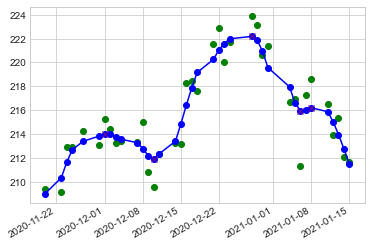

In [7]:

def find_head_and_shoulders(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        e3_is_greater_than_e1 = extrema_y_vals[2] > extrema_y_vals[0]
        e3_is_greater_than_e5 = extrema_y_vals[2] > extrema_y_vals[4]
        
        e2_e4_avg = (extrema_y_vals[1] + extrema_y_vals[3]) / 2
        e2_within_15b_of_e2_e4_avg = abs(extrema_y_vals[1] / e2_e4_avg - 1) <= 0.015
        e4_within_15b_of_e2_e4_avg = abs(extrema_y_vals[3] / e2_e4_avg - 1) <= 0.015
        e2_and_e4_within_15_basis_points_of_their_average = e4_within_15b_of_e2_e4_avg and e2_within_15b_of_e2_e4_avg
        
        e1_e5_avg = (extrema_y_vals[0] + extrema_y_vals[4]) / 2
        e1_within_15b_of_e1_e5_avg = abs(extrema_y_vals[0] / e2_e4_avg - 1) <= 0.015
        e5_within_15b_of_e1_e5_avg = abs(extrema_y_vals[4] / e2_e4_avg - 1) <= 0.015
        e1_and_e5_within_15_basis_points_of_their_average = e1_within_15b_of_e1_e5_avg and e5_within_15b_of_e1_e5_avg
        
        
        price_series_has_head_and_shoulders = (
            e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5 
            and e2_and_e4_within_15_basis_points_of_their_average and e1_and_e5_within_15_basis_points_of_their_average)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_head_and_shoulders = find_head_and_shoulders(window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_head_and_shoulders[0], )

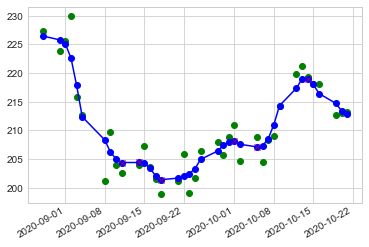

In [8]:

def find_inverse_head_and_shoulders(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_minima = extrema_y_vals[0] < extrema_y_vals[1]
        e3_is_greater_than_e1 = extrema_y_vals[2] < extrema_y_vals[0]
        e3_is_greater_than_e5 = extrema_y_vals[2] < extrema_y_vals[4]
        
        e2_e4_avg = (extrema_y_vals[1] + extrema_y_vals[3]) / 2
        e2_within_15b_of_e2_e4_avg = abs(extrema_y_vals[1] / e2_e4_avg - 1) <= 0.015
        e4_within_15b_of_e2_e4_avg = abs(extrema_y_vals[3] / e2_e4_avg - 1) <= 0.015
        e2_and_e4_within_15_basis_points_of_their_average = e4_within_15b_of_e2_e4_avg and e2_within_15b_of_e2_e4_avg
        
        e1_e5_avg = (extrema_y_vals[0] + extrema_y_vals[4]) / 2
        e1_within_15b_of_e1_e5_avg = abs(extrema_y_vals[0] / e2_e4_avg - 1) <= 0.015
        e5_within_15b_of_e1_e5_avg = abs(extrema_y_vals[4] / e2_e4_avg - 1) <= 0.015
        e1_and_e5_within_15_basis_points_of_their_average = e1_within_15b_of_e1_e5_avg and e5_within_15b_of_e1_e5_avg
        
        
        price_series_has_head_and_shoulders = (
            e1_is_local_minima and e3_is_greater_than_e1 and e3_is_greater_than_e5 
            and e2_and_e4_within_15_basis_points_of_their_average and e1_and_e5_within_15_basis_points_of_their_average)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_inverse_head_and_shoulders = find_inverse_head_and_shoulders(window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_inverse_head_and_shoulders[0], )

In [9]:
def find_broadening_top(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        cond1 = extrema_y_vals[0] < extrema_y_vals[2]
        e3_is_greater_than_e1 = extrema_y_vals[2] < extrema_y_vals[4]
        e3_is_greater_than_e5 = extrema_y_vals[1] > extrema_y_vals[3]
        
        price_series_has_head_and_shoulders = (
            cond1 and e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_broadening_top = find_broadening_top(window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_broadening_top[0], )

IndexError: list index out of range

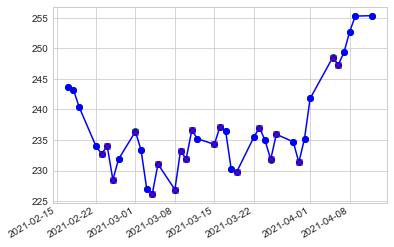

In [10]:
def find_broadening_bottom(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] < extrema_y_vals[1]
        cond1 = extrema_y_vals[0] > extrema_y_vals[2]
        e3_is_greater_than_e1 = extrema_y_vals[2] > extrema_y_vals[4]
        e3_is_greater_than_e5 = extrema_y_vals[1] < extrema_y_vals[3]
        
        price_series_has_head_and_shoulders = (
            cond1 and e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_broadening_bottom = find_broadening_bottom(window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_broadening_bottom[0], )

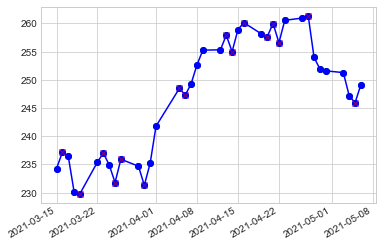

In [11]:
def find_triangle_top(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        cond1 = extrema_y_vals[0] > extrema_y_vals[2]
        e3_is_greater_than_e1 = extrema_y_vals[2] > extrema_y_vals[4]
        e3_is_greater_than_e5 = extrema_y_vals[1] < extrema_y_vals[3]
        
        price_series_has_head_and_shoulders = (
            cond1 and e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_triangle_top = find_triangle_top(
    window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_triangle_top[0], )

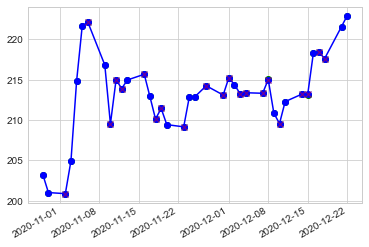

In [12]:
def find_triangle_bottom(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] < extrema_y_vals[1]
        cond1 = extrema_y_vals[0] < extrema_y_vals[2]
        e3_is_greater_than_e1 = extrema_y_vals[2] < extrema_y_vals[4]
        e3_is_greater_than_e5 = extrema_y_vals[1] > extrema_y_vals[3]
        
        price_series_has_head_and_shoulders = (
            cond1 and e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_triangle_top = find_triangle_bottom(
    window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_triangle_top[0], )

In [14]:

# TODO: No examples found in price series, 
# TODO: Need to make unit test or find another price series

def find_rectangle_top(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        
        tops_list = extrema_y_vals[::2]
        bottoms_list = extrema_y_vals[1::2]
        
        avg_tops = sum(tops_list) / len(tops_list)
        avg_bottoms = sum(bottoms_list) / len(bottoms_list)
        
        avg_tops_threshold_breached = [
            i for i in tops_list if abs(i/avg_tops) >= .75]
        avg_bottoms_threshold_breached = [
            i for i in bottoms_list if abs(i/avg_bottoms) >= .75]
        
        any_bottoms_breached_theshold = len(avg_tops_threshold_breached) == 0 
        any_tops_breached_theshold = len(avg_tops_threshold_breached) == 0
        
        lowest_top_greater_than_highest_bottom = max(bottoms_list) < min(tops_list)
        
        price_series_has_head_and_shoulders = (
            e1_is_local_maxima and any_bottoms_breached_theshold 
            and any_tops_breached_theshold 
            and lowest_top_greater_than_highest_bottom)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_triangle_top = find_rectangle_top(
    window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_triangle_top[0], )

IndexError: list index out of range

In [15]:

# TODO: No examples found in price series, 
# TODO: Need to make unit test or find another price series

def find_rectangle_bottom(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] < extrema_y_vals[1]
        
        bottoms_list = extrema_y_vals[::2]
        tops_list = extrema_y_vals[1::2]
        
        avg_tops = sum(tops_list) / len(tops_list)
        avg_bottoms = sum(bottoms_list) / len(bottoms_list)
        
        avg_tops_threshold_breached = [
            i for i in tops_list if abs(i/avg_tops) >= .75]
        avg_bottoms_threshold_breached = [
            i for i in bottoms_list if abs(i/avg_bottoms) >= .75]
        
        any_bottoms_breached_theshold = len(avg_tops_threshold_breached) == 0 
        any_tops_breached_theshold = len(avg_tops_threshold_breached) == 0
        
        lowest_top_greater_than_highest_bottom = max(bottoms_list) < min(tops_list)
        
        price_series_has_head_and_shoulders = (
            e1_is_local_maxima and any_bottoms_breached_theshold 
            and any_tops_breached_theshold 
            and lowest_top_greater_than_highest_bottom)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_triangle_top = find_rectangle_bottom(
    window_data=window_data_greater_than_4_extrema)

plot_chart(price_series_data=window_data_triangle_top[0], )

IndexError: list index out of range

Double Top

In [18]:

# TODO: No examples found in price series, 
# TODO: Need to make unit test or find another price series

def find_double_top(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        extrema_x_vals = window_data[i]['extrema_x_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        
        e1_x = extrema_y_vals[0]
        e1_y = extrema_x_vals[0]
        
        local_maxima_ys_list = extrema_y_vals[::2]
        local_maxima_xs_list = extrema_x_vals[::2]
        
        local_maxima_after_initial = [
            {'y': local_maxima_ys_list[i], 'x': local_maxima_xs_list[i], } 
            for i in range(0, len(local_maxima_ys_list))
            if local_maxima_xs_list[i] - e1_x > 22 
            and abs((local_maxima_ys_list[i] / (
                (local_maxima_ys_list[i] + e1_y) / 2) - 1)) < 0.015
            and abs((e1_y / (
                (local_maxima_ys_list[i] + e1_y) / 2) - 1)) < 0.015
            and max(local_maxima_ys_list[0:i]) < local_maxima_ys_list[i]
        ]

        
        price_series_has_double_top = len(local_maxima_after_initial) > 0
        
        if price_series_has_double_top:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_double_top = find_double_top(
    window_data=result_list_2)

plot_chart(price_series_data=window_data_double_top[0], )

IndexError: list index out of range

Double Bottom

In [19]:

# TODO: No examples found in price series, 
# TODO: Need to make unit test or find another price series

def find_double_bottom(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        extrema_x_vals = window_data[i]['extrema_x_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] < extrema_y_vals[1]
        
        e1_x = extrema_y_vals[0]
        e1_y = extrema_x_vals[0]
        
        local_maxima_ys_list = extrema_y_vals[::2]
        local_maxima_xs_list = extrema_x_vals[::2]
        
        local_maxima_after_initial = [
            {'y': local_maxima_ys_list[i], 'x': local_maxima_xs_list[i], } 
            for i in range(0, len(local_maxima_ys_list))
            if local_maxima_xs_list[i] - e1_x > 22 
            and abs((local_maxima_ys_list[i] / (
                (local_maxima_ys_list[i] + e1_y) / 2) - 1)) < 0.015
            and abs((e1_y / (
                (local_maxima_ys_list[i] + e1_y) / 2) - 1)) < 0.015
            and min(local_maxima_ys_list[0:i]) < local_maxima_ys_list[i]
        ]

        
        price_series_has_double_top = len(local_maxima_after_initial) > 0
        
        if price_series_has_double_top:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_double_bottom = find_double_bottom(
    window_data=result_list_2)

plot_chart(price_series_data=window_data_double_top[0], )


IndexError: list index out of range